In [36]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB # modele d'exemple a modifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint
import pickle

In [37]:
# Import data
data = pd.read_csv('data/train_diabetes_health_indicators.csv')
data['Diabetes_012'] = data['Diabetes_012'].astype(int)

X = data.drop(columns=['Diabetes_012'])
y = data['Diabetes_012']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Analyse data
#--- exemple ---
data.head()
num_duplicates = data.duplicated().sum()

#Ici je drop la colonne Unnamed: 0, qui n'apporte rien au dataset
data.drop("Unnamed: 0", axis=1, inplace=True)




In [39]:
data.shape

(47276, 22)

In [40]:

data.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,...,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000,47276.000000
mean,0.305800,0.419325,0.401980,0.964337,28.939081,0.408114,0.038265,0.085752,0.781284,0.619807,...,0.962899,0.062696,2.473560,3.929245,3.761126,0.152720,0.476986,7.887829,5.142482,6.931191
std,0.703757,0.493454,0.490303,0.185450,6.562661,0.491490,0.191837,0.280000,0.413380,0.485439,...,0.189012,0.242417,1.027017,7.861948,8.239428,0.359721,0.499475,3.227736,0.945945,2.376979
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,28.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,4.000000,2.000000,0.000000,1.000000,10.000000,6.000000,9.000000
max,2.000000,1.000000,1.000000,1.000000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,11.000000


In [41]:
from sklearn.preprocessing import StandardScaler

#A l'aide de scaler je cherche à normaliser les données, afin qu'elles
# soient plus équilibrés
scaler = StandardScaler()

#J'entraîne mon jeu de données
scaler.fit(X_train)

X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [42]:
from scipy.stats import pearsonr

pearson_list = []
for l in list(X.columns):
    p,_ = pearsonr(X[l], y)
    pearson_list.append(abs(p))
    
p_value=pd.Series(pearson_list,index=X.columns)
p_value.sort_values(ascending=False,inplace=True)
high_score_features_pearson = list(p_value.index[:15]) #we took only 15 features
print(high_score_features_pearson)

X=X[high_score_features_pearson]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol', 'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Income', 'PhysActivity', 'Education', 'Stroke', 'CholCheck', 'HvyAlcoholConsump', 'Smoker']


In [43]:
from imblearn.over_sampling import RandomOverSampler

# Ici, je crée une instance de SMOTE
smote = SMOTE(random_state=42)

# Après on applique SMOTE sur l'ensemble d'entraînement uniquement
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Je crée et j'entraîne le modèle sur les données équilibrées
rf_classifier = RandomForestClassifier(random_state=42) 
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Ensuite je fais des prédictions sur l'ensemble de test
y_pred = rf_classifier.predict(X_test)

# Et enfin je fais le rapport de classification afin d'obtenir
# les métriques precision, recall et f1-score
print(classification_report(y_test, y_pred))

# Dans notre cas, on peut observer  que la précision pour classe 0
# est élevée tandis que pour celle de classe 1, la precision n'est
# pas exceptionnel. Cela est dû au fait que la classe 1, à une part
# qui est très faible (2,3%).

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7899
           1       0.05      0.01      0.02       220
           2       0.42      0.26      0.32      1337

    accuracy                           0.82      9456
   macro avg       0.44      0.40      0.41      9456
weighted avg       0.78      0.82      0.80      9456



In [44]:
data.nunique()

Diabetes_012             3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     74
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                30
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                  11
dtype: int64

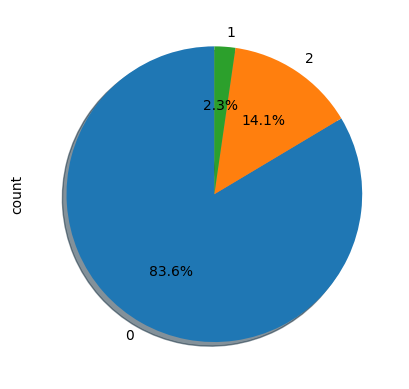

In [45]:
data["Diabetes_012"].value_counts().plot.pie( autopct='%1.1f%%',shadow=True, startangle=90);
#Ici avec le pie, on peut observer que la classe 1 est faiblement représentée

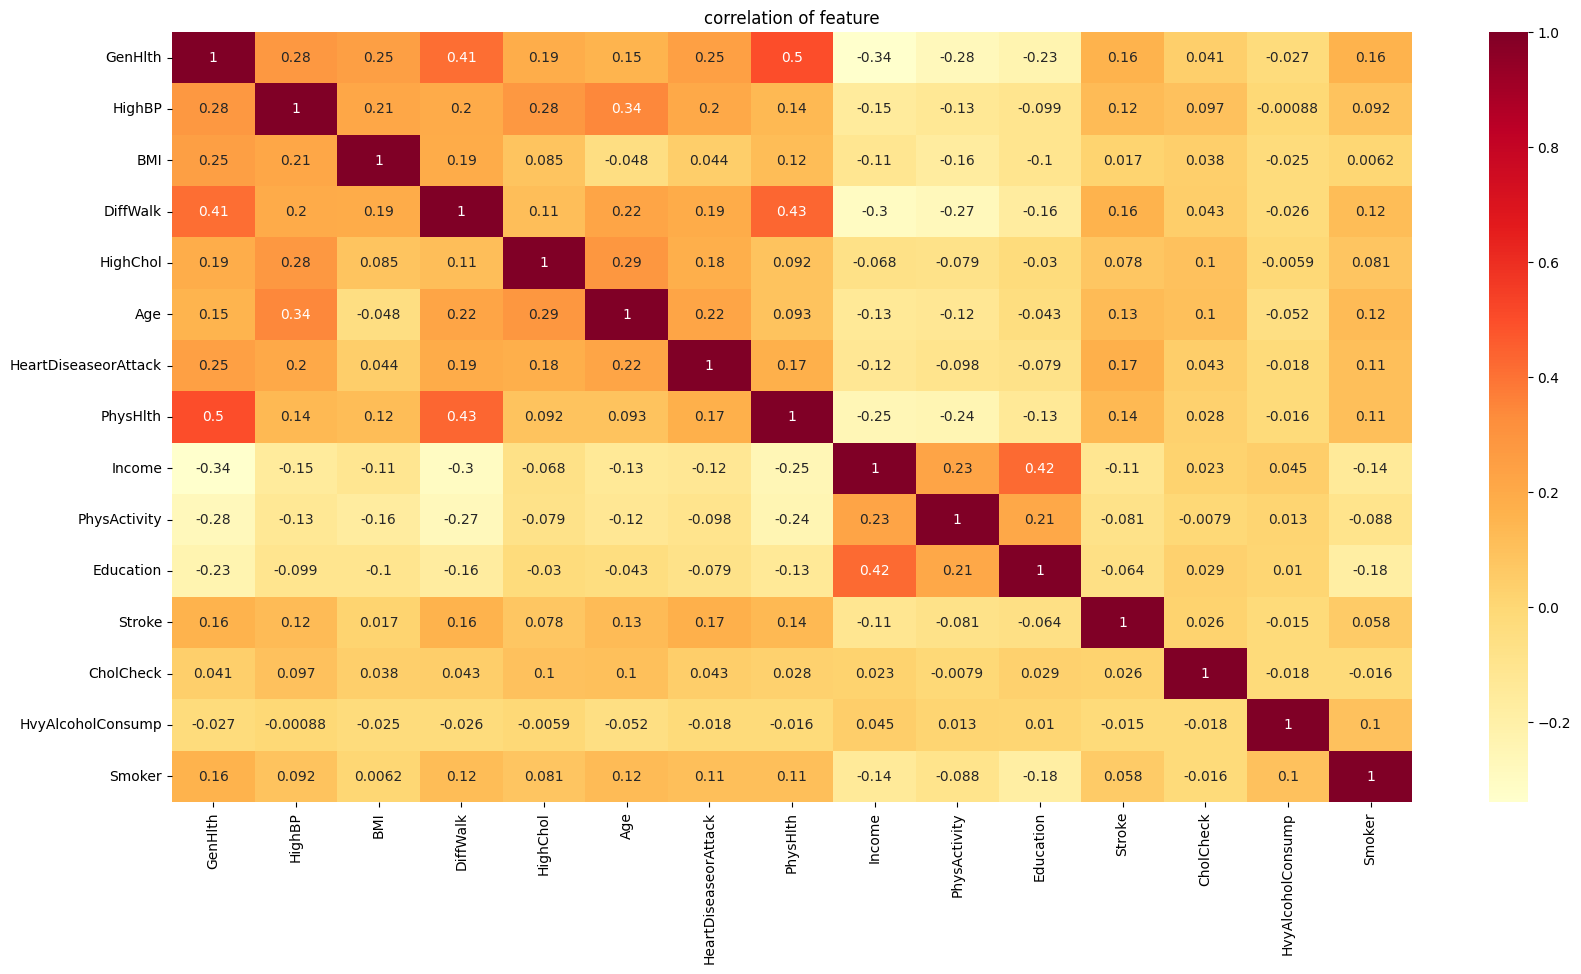

In [46]:
plt.figure(figsize = (20,10))
sns.heatmap(X.corr(),annot=True , cmap ='YlOrRd' )
plt.title("correlation of feature")
plt.show()


In [47]:
# Export model
pickle.dump(rf_classifier, open("branch_random_forest.pkl", "wb"))

,GenHlth,HighBP,BMI,DiffWalk,HighChol,Age,HeartDiseaseorAttack,PhysHlth,Income,PhysActivity,Education,Stroke,CholCheck,HvyAlcoholConsump,Smoker
21332,1.0,1,27.0,1.0,1.0,10,0.0,0.0,8.0,1,6.0,0.0,1,1,0.0
18106,2.0,1,25.0,0.0,1.0,11,0.0,0.0,8.0,1,5.0,0.0,1,0,0.0
30664,4.0,1,27.0,1.0,1.0,11,1.0,14.0,5.0,1,4.0,1.0,1,0,1.0
26704,2.0,0,28.0,0.0,1.0,9,0.0,0.0,6.0,0,3.0,0.0,1,0,1.0
21739,3.0,0,30.0,0.0,1.0,9,0.0,0.0,10.0,1,6.0,0.0,1,0,0.0
